# 1. Leaky Aquifer Test - Dalem

### Import packages

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import timflow.transient as tft 

plt.rcParams['figure.figsize'] = [5, 3]

### Introduction and Conceptual Model
This example is a pumping test from Dalem (Kruseman et al., 1970), the Netherlands. The hydrogeological cross-section is composed of the following elements: 
* an initial 8 m deep aquitard layer,
* followed by an aquifer from 8 m to 45 m depth,
* the layer underlying the aquifer is considered an aquiclude.

The pumping well is placed at the aquifer, and drawdown is recorded at four different piezometers, 30, 60, 90 and 120 m away from the well. The pumping lasted 8 hours in total at a rate of 761 m$^3$/d. There is a river 1500 m away from the well. The tide affects both river and well levels. Data has been previously corrected for the tide effect.

<img src="./figs/Dalem.png" style="width:400pt">

### Load Data

In [56]:
# data of observation well 30 m away from pumping well
data1 = np.loadtxt("data/dalem_p30.txt", skiprows=1)
t1 = data1[:, 0] 
h1 = data1[:, 1] 

# data of observation well 60 m away from pumping well
data2 = np.loadtxt("data/dalem_p60.txt", skiprows=1)
t2 = data2[:, 0]
h2 = data2[:, 1]

# data of observation well 90 m away from pumping well
data3 = np.loadtxt("data/dalem_p90.txt", skiprows=1)
t3 = data3[:, 0]
h3 = data3[:, 1]

# data of observation well 120 m away from pumping well
data4 = np.loadtxt("data/dalem_p120.txt", skiprows=1)
t4 = data4[:, 0]
h4 = data4[:, 1]

### Parameters and model

In [59]:
# known parameters
H = 37  # aquifer thickness in m
zt = -8  # top boundary of aquifer in m
zb = zt - H  # bottom boundary of the aquifer in m
Q = 761  # constant pumping rate in m^3/d
t = 8 / 24  # total pumping time in days (8 hours = 0.34 days)

r1 = 30  # distance from pumping well to observation well 1 in m
r2 = 60  # distance from pumping well to observation well 2 in m
r3 = 90  # distance from pumping well to observation well 3 in m
r4 = 120  # distance from pumping well to observation well 4 in m

In many situations, we cannot ignore the leakage potential of overlying and underlying formations to aquifers, and we cannot conceptualize them as confined. `timflow` is capable of modelling and adjusting parameters to leaky, semi-confined aquifers.

In [62]:
# unkonwn parameters: kaq, Saq, c
ml= tft.ModelMaq(
    kaq=10, z=[0, zt, zb], c=500, Saq=0.001, topboundary="semi", tmin=0.01, tmax=1
)
w = tft.Well(ml, xw=0, yw=0, tsandQ=[(0, Q), (0.34, 0)])
ml.solve(silent="True")

### Estimate aquifer parameters

In [65]:
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq0", initial=10, layers=0)
cal.set_parameter(name="Saq0", initial=1e-4, layers=0)
cal.set_parameter(name="c0", initial=500, pmin=0, layers=0)

cal.series(name="obs1", x=30, y=0, t=t1, h=h1, layer=0)
cal.series(name="obs2", x=60, y=0, t=t2, h=h2, layer=0)
cal.series(name="obs3", x=90, y=0, t=t3, h=h3, layer=0)
cal.series(name="obs4", x=120, y=0, t=t4, h=h4, layer=0)
cal.fit(report=True)

.....................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 51
    # variables        = 3
    chi-square         = 0.00178546
    reduced chi-square = 3.7197e-05
    Akaike info crit   = -517.255127
    Bayesian info crit = -511.459650
[[Variables]]
    kaq0_0_0:  45.3318750 +/- 1.18522014 (2.61%) (init = 10)
    Saq0_0_0:  4.7623e-05 +/- 3.1043e-06 (6.52%) (init = 0.0001)
    c0_0_0:    331.164978 +/- 76.1868842 (23.01%) (init = 500)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_0_0, Saq0_0_0) = -0.7707
    C(kaq0_0_0, c0_0_0)   = +0.7616
    C(Saq0_0_0, c0_0_0)   = -0.2992


In [67]:
display(cal.parameters)
print("RMSE:", cal.rmse())

,layers,optimal,std,perc_std,pmin,pmax,initial,inhoms,parray
kaq0_0_0,0,45.331875,1.185220,2.614540,-inf,inf,10.0000,None,[[45.33187498569421]]
Saq0_0_0,0,0.000048,0.000003,6.518552,-inf,inf,0.0001,None,[[4.762262320317127e-05]]
c0_0_0,0,331.164978,76.186884,23.005719,0.0,inf,500.0000,None,[[331.1649782944002]]


RMSE: 0.005916843158052398


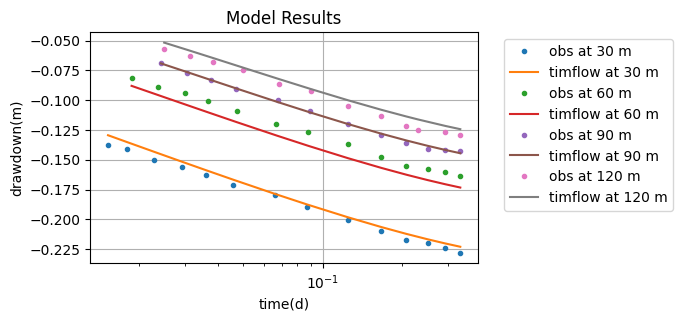

In [78]:
hm_1 = ml.head(r1, 0, t1)
plt.semilogx(t1, h1, ".", label="obs at 30 m")
plt.semilogx(t1, hm_1[0], label="timflow at 30 m")

hm_2 = ml.head(r2, 0, t2)
plt.semilogx(t2, h2, ".", label="obs at 60 m")
plt.semilogx(t2, hm_2[0], label="timflow at 60 m")

hm_3 = ml.head(r3, 0, t3)
plt.semilogx(t3, h3, ".", label="obs at 90 m")
plt.semilogx(t3, hm_3[0], label="timflow at 90 m")

hm_4 = ml.head(r4, 0, t4)
plt.semilogx(t4, h4, ".", label="obs at 120 m")
plt.semilogx(t4, hm_4[0], label="timflow at 120 m")

plt.xlabel("time(d)")
plt.ylabel("drawdown(m)")
plt.title("Model Results")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid();

### Comparison of results

The performance of `timflow` was evaluated by comparison with other numerical models and with parameter values reported in Kruseman and de Ridder (1970). The published values were obtained by graphical matching to the Hantush family of type curves (Hantush, 1955). In addition to the `timflow` results and the literature values, results from AQTESOLV (Duffield, 2007) and MLU (Carlson & Randall, 2012) are included for comparison.

Overall, all models yield similar estimates of the aquifer hydraulic conductivity. However, the `timflow` results differ substantially from the MLU and AQTESOLV solutions with respect to aquitard storage and hydraulic resistance.

In [73]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "c [d]", "RMSE [m]"],
    index=["timflow", "AQTESOLV", "MLU", "Hantush"],
)

t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())
t.loc["AQTESOLV"] = [49.286, 4.559e-05, 745.156, 0.007245]
t.loc["MLU"] = [45.186, 3.941e-05, 769.200, 0.005941]
t.loc["Hantush"] = [45.332, 4.762e-5, 331.141, 0.005917]

t_formatted = t.style.format(
    {
        "k [m/d]": "{:.2f}", 
        "Ss [1/m]": "{:.2e}",
        "c [d]": "{:.0f}",
        "RMSE [m]": "{:.3f}"
    }
)
t_formatted

,k [m/d],Ss [1/m],c [d],RMSE [m]
timflow,45.33,4.76e-05,331,0.006
AQTESOLV,49.29,4.56e-05,745,0.007
MLU,45.19,3.94e-05,769,0.006
Hantush,45.33,4.76e-05,331,0.006


## References

* Bakker, M. (2013), Semi-analytic modeling of transient multi-layer flow with TTim, Hydrogeol J 21, 935–943, https://doi.org/10.1007/s10040-013-0975-2 
* Carlson, F. and Randall, J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510.
* Duffield, G.M., (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Kruseman, G.P., De Ridder, N.A. and Verweij, J.M., (1970), Analysis and evaluationof pumping test data, volume 11, International institute for land reclamation and improvement The Netherlands.
* Newville, M., Stensitzki, T., Allen, D.B. and Ingargiola, A. (2014), LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python, https://dx.doi.org/10.5281/zenodo.11813, https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).